# Convolutional Neural Networks

This notebook covers CNNs from multiple angles: using pretrained models, fine-tuning, implementing convolutions from scratch, and building a custom classifier.

**Topics covered:**
- Loading and using pretrained models (VGG16, ResNet18)
- Fine-tuning on a new dataset (CIFAR-10)
- Manual convolution and pooling operations
- Data augmentation and information theory
- Building a CNN classifier from scratch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## Part 1: Pretrained Models

VGG16 is a classic CNN architecture trained on ImageNet (1.2M images, 1000 classes). I'll load it and see how many parameters it has.

In [2]:
import torchvision.models as models
from torchvision.models import vgg16, VGG16_Weights

vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 162MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
#counting trainable parameters
total_params = sum(p.numel() for p in vgg.parameters() if p.requires_grad)
print(f"VGG16 has {total_params:,} trainable parameters")
#that's a lot of parameters - most are in the fully connected layers

VGG16 has 138,357,544 trainable parameters


In [4]:
#using VGG16 to classify an image
weights = VGG16_Weights.DEFAULT
model = models.vgg16(weights=weights)
model.eval()

#loading and preprocessing the image
img = Image.open('data/tiger_shark.JPEG')
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0)

#getting predictions
with torch.no_grad():
    prediction = model(batch).squeeze(0).softmax(0)

#top 5 predictions
top5_prob, top5_idx = torch.topk(prediction, 5)
for i in range(5):
    category = weights.meta['categories'][top5_idx[i]]
    prob = top5_prob[i].item() * 100
    print(f"{category}: {prob:.1f}%")

tiger shark: 99.8%
great white shark: 0.2%
hammerhead: 0.0%
sturgeon: 0.0%
coho: 0.0%


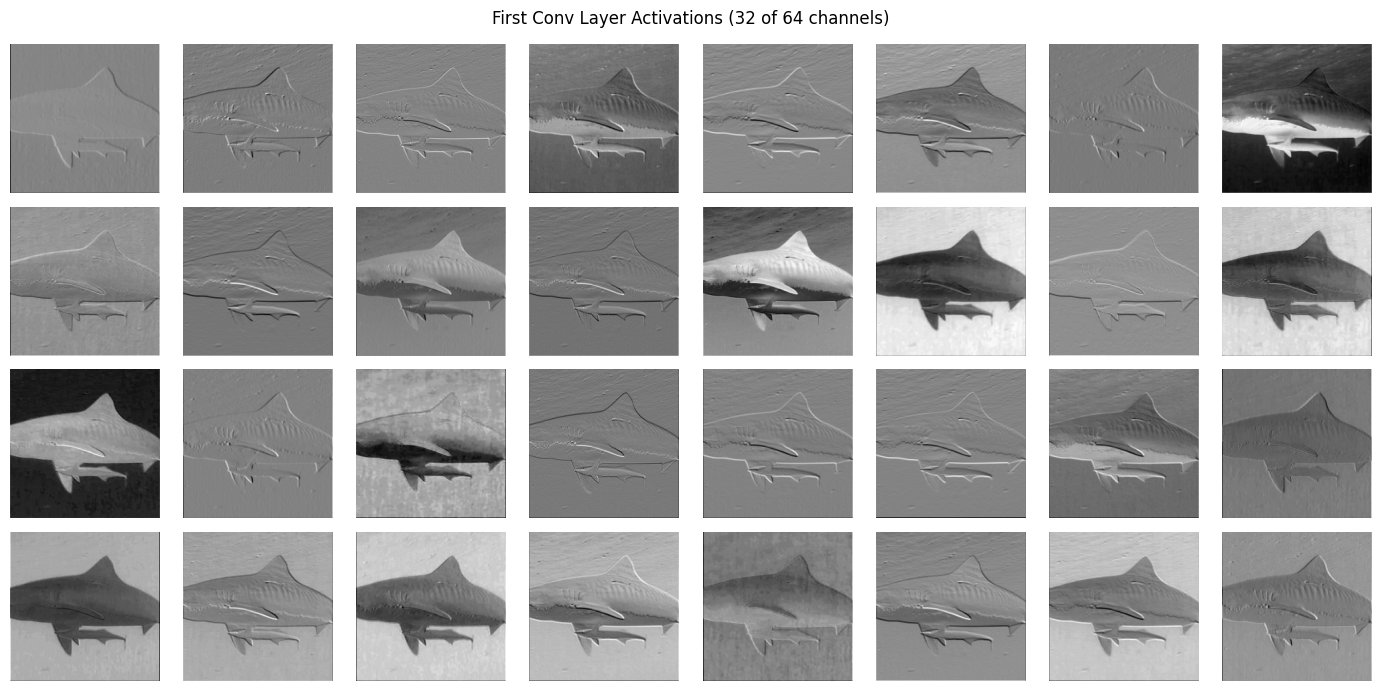

In [5]:
#visualizing the first conv layer activations
first_conv = model.features[0]

with torch.no_grad():
    conv_output = first_conv(batch)

fig, axes = plt.subplots(4, 8, figsize=(14, 7))
for i, ax in enumerate(axes.flat):
    if i < conv_output.shape[1]:
        ax.imshow(conv_output[0, i].cpu(), cmap='gray')
    ax.axis('off')
plt.suptitle('First Conv Layer Activations (32 of 64 channels)')
plt.tight_layout()
plt.show()

## Part 2: Fine-tuning ResNet18 on CIFAR-10

Instead of training from scratch, I'll take a pretrained ResNet18 and adapt it to classify CIFAR-10 (10 classes instead of ImageNet's 1000). This is called transfer learning.

In [6]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

#loading CIFAR-10
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Training: {len(train_data)} images")
print(f"Test: {len(test_data)} images")
print(f"Classes: {train_data.classes}")

100%|██████████| 170M/170M [00:01<00:00, 104MB/s]


Training: 50000 images
Test: 10000 images
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
#loading pretrained ResNet18 and modifying the final layer
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

#freezing all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

#replacing the final layer: 1000 ImageNet classes -> 10 CIFAR classes
#I keep the original layer and add a new one on top
original_fc = model.fc
model.fc = nn.Sequential(
    original_fc,
    nn.ReLU(),
    nn.Linear(1000, 10)
)

print("Modified classifier:")
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 62.3MB/s]

Modified classifier:
Sequential(
  (0): Linear(in_features=512, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=10, bias=True)
)


In [8]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

print(f"Before fine-tuning: {evaluate(model, test_loader):.1f}% accuracy")

Before fine-tuning: 9.7% accuracy


In [9]:
#fine-tuning only the new layers
trainable_params = [p for p in model.fc.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.3f}, Test Acc={acc:.1f}%")

Epoch 1: Loss=1.889, Test Acc=39.3%


Epoch 2: Loss=1.782, Test Acc=40.1%


Epoch 3: Loss=1.750, Test Acc=41.5%


Epoch 4: Loss=1.748, Test Acc=41.4%


Epoch 5: Loss=1.732, Test Acc=41.4%


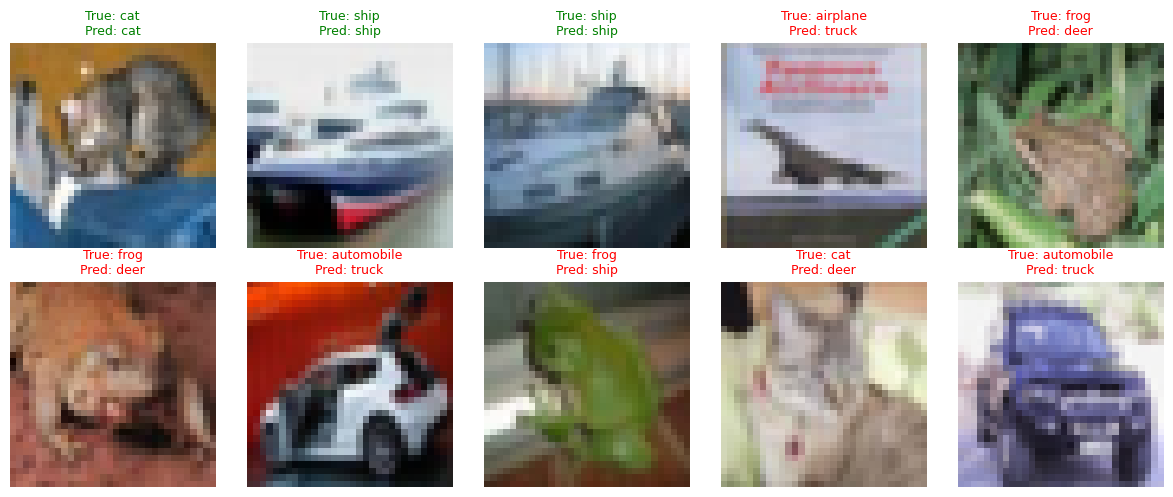

In [10]:
#visualizing some predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
model.eval()

for i, ax in enumerate(axes.flat):
    img, label = test_data[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0)).argmax().item()

    ax.imshow(img.permute(1, 2, 0))
    color = 'green' if pred == label else 'red'
    ax.set_title(f"True: {test_data.classes[label]}\nPred: {test_data.classes[pred]}",
                 fontsize=9, color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Part 3: Manual Convolution and Pooling

To understand what CNNs actually do, I implemented convolution and max pooling from scratch using only numpy.

In [11]:
def conv2d(image, kernel):
    """Applies a 2D convolution with a given kernel."""
    h, w = image.shape
    kh, kw = kernel.shape

    #output size (no padding, stride=1)
    out_h = h - kh + 1
    out_w = w - kw + 1
    output = np.zeros((out_h, out_w))

    #sliding the kernel over the image
    for i in range(out_h):
        for j in range(out_w):
            region = image[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)

    return output

def max_pool2d(image, pool_size=2):
    """Applies max pooling with given pool size."""
    h, w = image.shape
    out_h = h // pool_size
    out_w = w // pool_size
    output = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            region = image[i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size]
            output[i, j] = np.max(region)

    return output

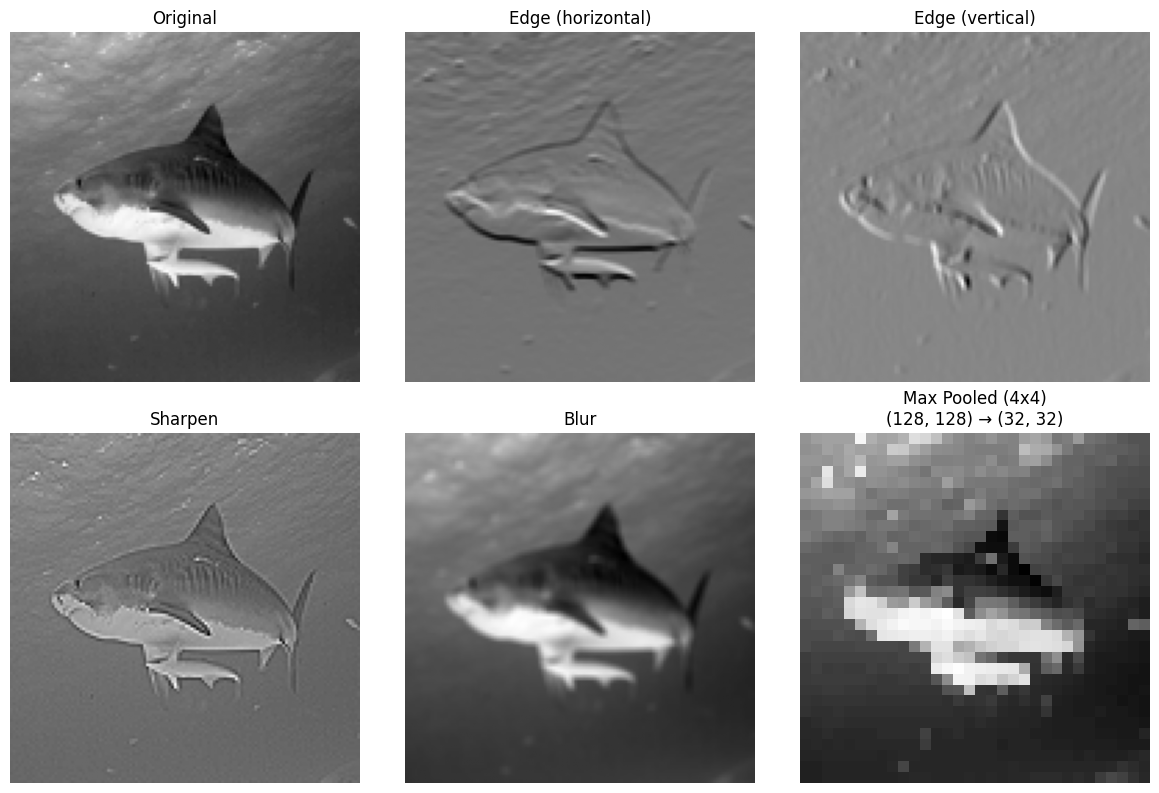

In [12]:
#testing on a sample image
from PIL import Image

#creating a simple test image
test_img = np.array(Image.open('data/tiger_shark.JPEG').convert('L').resize((128, 128))) / 255.0

#some classic kernels
kernels = {
    'Edge (horizontal)': np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]),
    'Edge (vertical)': np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]),
    'Sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
    'Blur': np.ones((3, 3)) / 9
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0, 0].imshow(test_img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for ax, (name, kernel) in zip(axes.flat[1:5], kernels.items()):
    convolved = conv2d(test_img, kernel)
    ax.imshow(convolved, cmap='gray')
    ax.set_title(name)
    ax.axis('off')

#showing max pooling effect
pooled = max_pool2d(test_img, pool_size=4)
axes[1, 2].imshow(pooled, cmap='gray')
axes[1, 2].set_title(f'Max Pooled (4x4)\n{test_img.shape} → {pooled.shape}')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Part 4: Data Augmentation and Information Theory

Data augmentation creates variations of training images. But how much *new* information does each augmentation add? I use entropy and mutual information to analyze this.

In [13]:
def image_entropy(img):
    """Computes Shannon entropy of an image."""
    hist, _ = np.histogram(img.ravel(), bins=256, range=(0, 1))
    p = hist / hist.sum()
    p = p[p > 0]  #avoid log(0)
    return -np.sum(p * np.log2(p))

def image_mutual_information(a, b):
    """Computes mutual information between two images."""
    ha = image_entropy(a)
    hb = image_entropy(b)

    #joint histogram
    h2d, _, _ = np.histogram2d(a.ravel(), b.ravel(), bins=256, range=[[0, 1], [0, 1]])
    p_ab = h2d / h2d.sum()
    p_ab = p_ab[p_ab > 0]
    hab = -np.sum(p_ab * np.log2(p_ab))

    #I(A;B) = H(A) + H(B) - H(A,B)
    return ha + hb - hab

In [14]:
import torchvision.transforms as transforms

#loading a sample image
cifar = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())
original_image, _ = cifar[0]

base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
])

#different augmentation strategies
augmentations = [
    transforms.Compose([base_transform, transforms.RandomRotation(45)]),
    transforms.Compose([base_transform, transforms.RandomHorizontalFlip(p=1.0)]),
    transforms.Compose([base_transform, transforms.RandomVerticalFlip(p=1.0)]),
    transforms.Compose([base_transform, transforms.GaussianBlur(kernel_size=5)]),
    transforms.Compose([base_transform, transforms.ColorJitter(brightness=0.5)]),
    transforms.Compose([base_transform, transforms.RandomPerspective(distortion_scale=0.5, p=1.0)]),
]

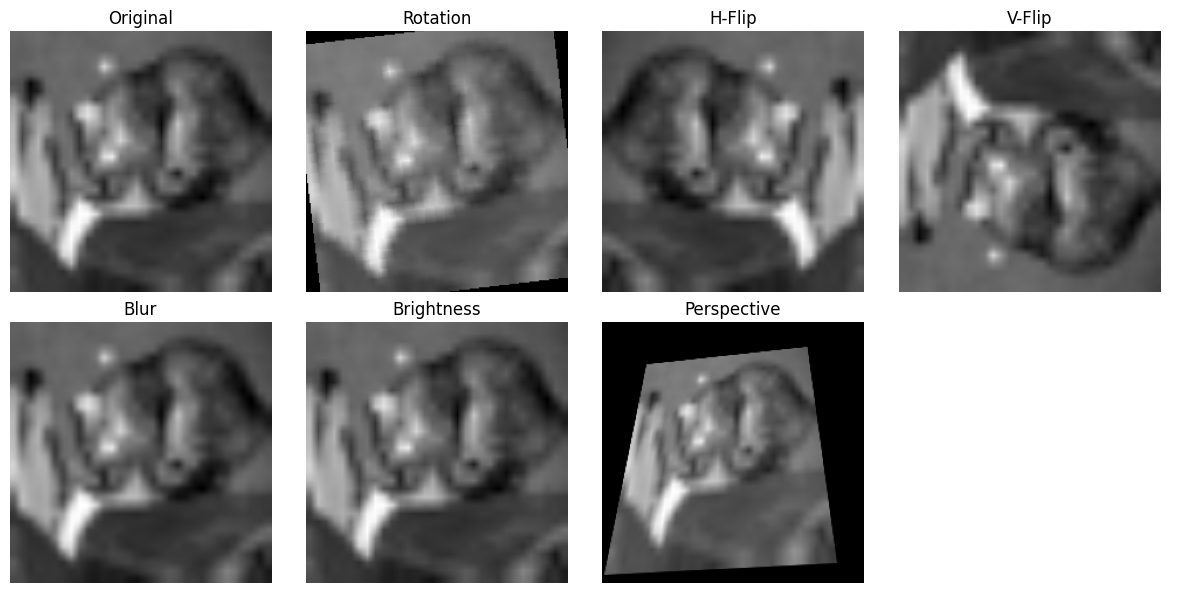

In [15]:
#visualizing the augmentations
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

axes[0].imshow(base_transform(original_image).squeeze().numpy(), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

names = ['Rotation', 'H-Flip', 'V-Flip', 'Blur', 'Brightness', 'Perspective']
for i, (aug, name) in enumerate(zip(augmentations, names)):
    axes[i+1].imshow(aug(original_image).squeeze().numpy(), cmap='gray')
    axes[i+1].set_title(name)
    axes[i+1].axis('off')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

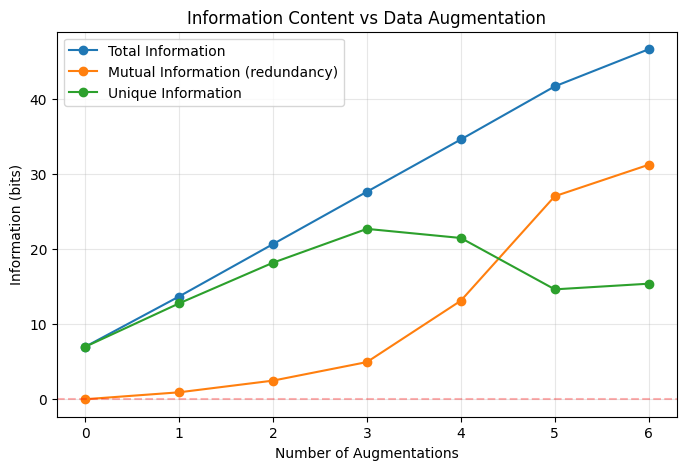

In [16]:
#tracking information as we add augmentations
base_img = base_transform(original_image).squeeze(0).numpy()
base_entropy = image_entropy(base_img)

total_info = [base_entropy]
mutual_info = [0]
unique_info = [base_entropy]
images = [base_img]

for aug in augmentations:
    current = aug(original_image).squeeze(0).numpy()
    current_entropy = image_entropy(current)

    #mutual information with all previous images
    mi = sum(image_mutual_information(prev, current) for prev in images)

    #unique information = entropy - shared information
    unique = current_entropy - mi

    total_info.append(total_info[-1] + current_entropy)
    mutual_info.append(mutual_info[-1] + mi)
    unique_info.append(total_info[-1] - mutual_info[-1])
    images.append(current)

plt.figure(figsize=(8, 5))
plt.plot(total_info, 'o-', label='Total Information')
plt.plot(mutual_info, 'o-', label='Mutual Information (redundancy)')
plt.plot(unique_info, 'o-', label='Unique Information')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Number of Augmentations')
plt.ylabel('Information (bits)')
plt.legend()
plt.title('Information Content vs Data Augmentation')
plt.grid(alpha=0.3)
plt.show()

**Observation:** The first few augmentations add genuinely new information, but after a point, redundancy grows faster than unique information. This suggests there's diminishing returns to adding more augmentations - at some point you're just adding noise, not signal.

However, uniqueness alone isn't enough - a random noise image would be very "unique" but completely useless for training.

---

## Part 5: Building a CNN Classifier (Crosses vs Pluses)

Now I build a CNN from scratch to classify a custom dataset. The images are tiny (3x3 pixels) so this is more of a toy problem, but it demonstrates the full pipeline.

In [17]:
import h5py
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#loading the dataset
with h5py.File('data/crosses_and_pluses.h5', 'r') as f:
    data = f['data'][:]
    labels = f['labels'][:]

encoder = LabelEncoder()
labels = encoder.fit_transform(labels.ravel())

print(f"Data shape: {data.shape}")
print(f"Classes: {encoder.classes_}")
print(f"Label distribution: {np.bincount(labels)}")

Data shape: (300, 3, 3, 3)
Classes: [b'cross' b'plus']
Label distribution: [150 150]


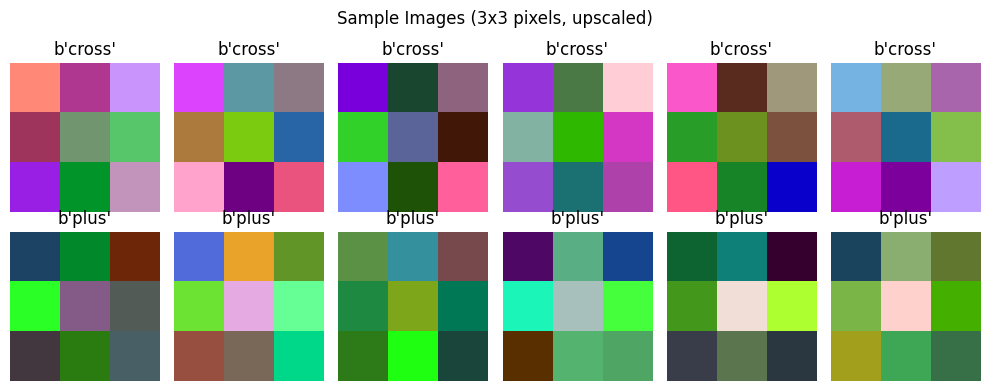

In [18]:
#visualizing some samples
fig, axes = plt.subplots(2, 6, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    #data is in (N, C, H, W) format, need to transpose to (H, W, C) for display
    img = data[i * 25].transpose(1, 2, 0)
    #normalizing to 0-1 for display
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.set_title(encoder.classes_[labels[i * 25]])
    ax.axis('off')

plt.suptitle('Sample Images (3x3 pixels, upscaled)')
plt.tight_layout()
plt.show()

In [19]:
#preparing data for PyTorch
X = torch.tensor(data, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Train: 201 samples
Test: 99 samples


In [20]:
#for 3x3 images, a full CNN is overkill - but i'll make a small one anyway to demonstrate
#the architecture: conv -> flatten -> linear -> output

class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            #input: (batch, 3, 3, 3)
            nn.Conv2d(3, 16, kernel_size=2, padding=0),  #-> (batch, 16, 2, 2)
            nn.ReLU(),
            nn.Flatten(),                                 #-> (batch, 16*2*2=64)
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = TinyCNN()
print(model)
print(f"Parameters: {sum(p.numel() for p in model.parameters())}")

TinyCNN(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=1, bias=True)
    (6): Sigmoid()
  )
)
Parameters: 1265


Epoch   0: Loss=0.6945, Train Acc=48.3%
Epoch  50: Loss=0.0001, Train Acc=100.0%
Epoch 100: Loss=0.0001, Train Acc=100.0%
Epoch 150: Loss=0.0000, Train Acc=100.0%


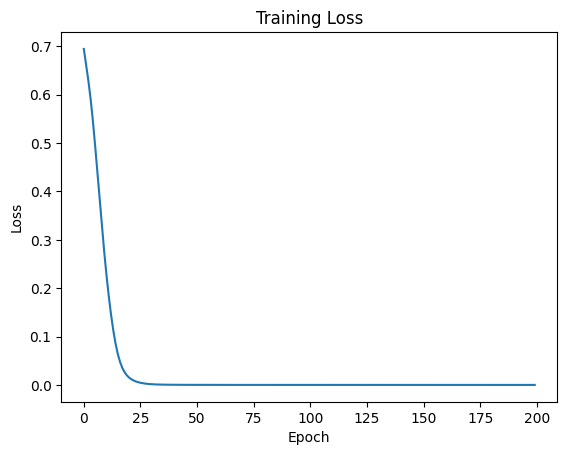

In [21]:
#training
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

losses = []
for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    pred = model(X_train)
    loss = criterion(pred, y_train)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 50 == 0:
        acc = ((pred > 0.5).float() == y_train).float().mean() * 100
        print(f"Epoch {epoch:3d}: Loss={loss.item():.4f}, Train Acc={acc:.1f}%")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [22]:
#evaluation
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

train_acc = ((train_pred > 0.5).float() == y_train).float().mean() * 100
test_acc = ((test_pred > 0.5).float() == y_test).float().mean() * 100

print(f"Train Accuracy: {train_acc:.1f}%")
print(f"Test Accuracy: {test_acc:.1f}%")

Train Accuracy: 100.0%
Test Accuracy: 100.0%


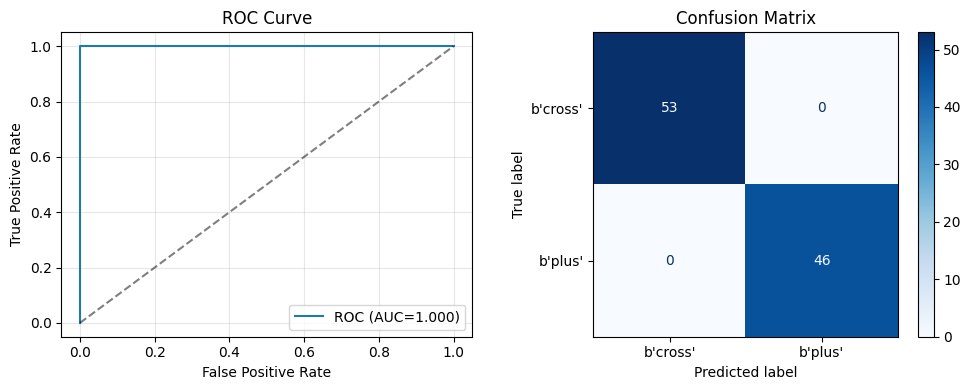

In [23]:
#ROC curve
fpr, tpr, _ = roc_curve(y_test.numpy(), test_pred.numpy())
auc = roc_auc_score(y_test.numpy(), test_pred.numpy())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

#confusion matrix
cm = confusion_matrix(y_test.numpy(), (test_pred > 0.5).float().numpy())
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
disp.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

## Summary

- **Pretrained models** like VGG16 contain 138M parameters trained on millions of images
- **Fine-tuning** lets us adapt these models to new tasks with minimal training
- **Convolution** is just sliding a kernel over an image and computing dot products
- **Data augmentation** adds useful variation, but with diminishing returns
- Even **tiny images** (3x3) can be classified with a simple CNN